In [1]:
#Copyright 2019, Seokjun Bu, Softcomputing LAB all rights reserved.
%matplotlib inline
import keras
import numpy as np
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = np.load('/content/drive/My Drive/test_colab/dataset_2_char_cat_45000_15000_140.npy')

In [4]:
X, Y = data[:, 1:], data[:, 0]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7, shuffle=True, random_state=11)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(42000, 14000) (42000,)
(18000, 14000) (18000,)


In [ ]:
Y_train_cat, Y_test_cat = to_categorical(Y_train), to_categorical(Y_test)

In [6]:
#Call Models
cnn_model = load_model('/content/drive/My Drive/test_colab/cnn.h5')
cae_model = load_model('/content/drive/My Drive/test_colab/cae.h5')
densenet = load_model('/content/drive/My Drive/test_colab/densenet.h5')












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [7]:
# Lock Weight
for i, l in enumerate(cae_model.layers):
    l.trainable = False
    l.name = 'cae_'+str(i)
cae_model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cae_0 (InputLayer)           (None, 14000)             0         
_________________________________________________________________
cae_1 (Reshape)              (None, 100, 140, 1)       0         
_________________________________________________________________
cae_2 (Conv2D)               (None, 100, 140, 32)      160       
_________________________________________________________________
cae_3 (MaxPooling2D)         (None, 50, 70, 32)        0         
_________________________________________________________________
cae_4 (Conv2D)               (None, 50, 70, 32)        4128      
_________________________________________________________________
cae_5 (MaxPooling2D)         (None, 25, 35, 32)        0         
_________________________________________________________________
cae_6 (Conv2D)               (None, 25, 35, 32)        4128

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


In [ ]:
# Test data Predict
Y_test_hat_ours = densenet.predict(X_test)
Y_test_hat_cnn = cnn_model.predict(X_test)

In [9]:
print(confusion_matrix(Y_test, np.argmax(Y_test_hat_ours, axis=1)))
print(confusion_matrix(Y_test, np.argmax(Y_test_hat_cnn, axis=1)))
print(classification_report(Y_test, np.argmax(Y_test_hat_ours, axis=1)))
print(classification_report(Y_test, np.argmax(Y_test_hat_cnn, axis=1)))

[[13173   373]
 [  544  3910]]
[[13226   320]
 [  662  3792]]
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     13546
         1.0       0.91      0.88      0.90      4454

    accuracy                           0.95     18000
   macro avg       0.94      0.93      0.93     18000
weighted avg       0.95      0.95      0.95     18000

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     13546
         1.0       0.92      0.85      0.89      4454

    accuracy                           0.95     18000
   macro avg       0.94      0.91      0.92     18000
weighted avg       0.94      0.95      0.94     18000




#### 실험 1. Zero-day attack에 대한 강건성 평가
- 무작위로 생성되는 피싱 URL의 특성을 반영하기 위해 Input URL에 백색잡음을 추가하는 방법을 고려하였다.

#### 실험 2. Input data imbalance issue 대응 평가
- Test data의 피싱데이터 비율을 증가시키면서 performance 측정하였다.

In [ ]:
def imbalance_gen(ratio):
  # X_test, Y_test 합치기
  stacked = np.hstack((Y_test.reshape(18000, 1), X_test))

  # 정상, 비정상 URL 분류
  benigns = stacked[stacked[:, 0] == 0]
  phishs = stacked[stacked[:, 0] == 1]

  # 생성된 데이터가 들어갈 자리 만들기
  X_gen = np.zeros((int(np.sum(Y_test)), X_test.shape[1]))
  Y_gen = np.zeros((int(np.sum(Y_test)),))

  # 정상개수, 비정상 url 개수
  num_benign = int(round(np.sum(Y_test)* (1 - ratio)))
  num_phish = int(np.sum(Y_test)) - num_benign

  # 정상, 비정상 Index list
  random_idxs_benign = np.arange(0, benigns.shape[0], 1).tolist()
  random_idxs_phish = np.arange(0, phishs.shape[0], 1).tolist()

  # 정상 url 고르기
  for i in range(num_benign):
    random_idx_benign = random.choice(random_idxs_benign)
    X_gen[i, :] = benigns[random_idx_benign, 1:]
    Y_gen[i] = benigns[random_idx_benign, 0]

  # 비정상 url 고르기
  for i in range(num_benign, num_benign + num_phish, 1):
    random_idx_phish = random.choice(random_idxs_phish)
    X_gen[i, :] = phishs[random_idx_phish, 1:]
    Y_gen[i] = phishs[random_idx_phish, 0]
  return X_gen, Y_gen

In [ ]:
# 실험 1.Noise robustness test
def noise_robustness(model1, model2, factor, strength):

  # Our Model
  recalls_ours = []
  precisions_ours = []
  accuracies_ours = []
  fallouts_ours = []

  # CNN Model
  recalls_cnn = []
  precisions_cnn = []
  accuracies_cnn = []
  fallouts_cnn = []

  for str in strength:
    noise = factor * np.random.normal(loc=0, scale=1 + str, size=(X_test.shape[0], X_test.shape[1]))

    y_hat_ours = model1.predict(X_test + noise)
    y_hat_cnn = model2.predict(X_test + noise)

    conf_mat_ours = confusion_matrix(Y_test, np.argmax(y_hat_ours, axis=1))
    conf_mat_cnn = confusion_matrix(Y_test, np.argmax(y_hat_cnn, axis=1))

    recall_ours = conf_mat_ours[1,1]/ np.sum(conf_mat_ours[1,:])
    precision_ours = conf_mat_ours[0,0]/ np.sum(conf_mat_ours[0,:])
    accuracy_ours = (conf_mat_ours[0,0]+conf_mat_ours[1,1])/np.sum(conf_mat_ours)
    fallout_ours = (conf_mat_ours[0,1])/np.sum(conf_mat_ours[0,:])
    
    recalls_ours.append(recall_ours)
    precisions_ours.append(precision_ours)
    accuracies_ours.append(accuracy_ours)
    fallouts_ours.append(fallout_ours)

    recall_cnn = conf_mat_cnn[1,1] / np.sum(conf_mat_cnn[1,:])
    precision_cnn = conf_mat_cnn[0,0] / np.sum(conf_mat_cnn[0,:])
    accuracy_cnn = (conf_mat_cnn[0,0]+conf_mat_cnn[1,1])/np.sum(conf_mat_cnn)
    fallout_cnn = (conf_mat_cnn[0,1])/np.sum(conf_mat_cnn[0,:])

    recalls_cnn.append(recall_cnn)
    precisions_cnn.append(precision_cnn)
    accuracies_cnn.append(accuracy_cnn)
    fallouts_cnn.append(fallout_cnn)

  return recalls_ours, precisions_ours, accuracies_ours, fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn
    

In [13]:
%%time
recalls_ours ,precisions_ours,accuracies_ours,fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn = noise_robustness(densenet, cnn_model, 0.01, [0,0.05,0.1,0.15,0.2])


CPU times: user 1min 38s, sys: 10.7 s, total: 1min 48s
Wall time: 1min 57s


##### Noise = factor(0.01) * N ($\mu$=0, $\sigma^2$+strength)

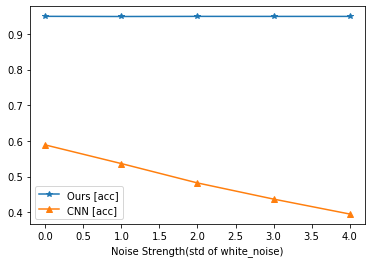

In [14]:
# plt.plot(recalls_ours, label = 'Ours [recall]', marker = 'o')
# plt.plot(recalls_cnn, label = 'CNN [recall]', marker = 's')
plt.plot(accuracies_ours, label = 'Ours [acc]', marker = '*')
plt.plot(accuracies_cnn, label = 'CNN [acc]', marker = '^')
plt.xlabel('Noise Strength(std of white_noise)')
plt.legend()

In [ ]:
# 실험 2. Zero day attack robustness test

def imbalance_robustness(model1, model2, ratios):
  #Our Results
  recalls_ours=[]
  precisions_ours=[]
  accuracies_ours=[]
  fallouts_ours=[]

  #CNN Results
  recalls_cnn=[]
  precisions_cnn=[]
  accuracies_cnn=[]
  fallouts_cnn=[]

  for ratio in ratios:
    X_gen, Y_gen = imbalance_gen(ratio=ratio)

    y_hat_ours = model1.predict(X_gen)
    y_hat_cnn = model2.predict(X_gen)

    conf_mat_ours = confusion_matrix(Y_gen, np.argmax(y_hat_ours, axis=1))
    conf_mat_cnn = confusion_matrix(Y_gen, np.argmax(y_hat_cnn, axis=1))

    recall_ours = conf_mat_ours[1,1]/np.sum(conf_mat_ours[1,:])
    precision_ours = conf_mat_ours[0,0]/np.sum(conf_mat_ours[0,:])
    accuracy_ours = (conf_mat_ours[0,0]+conf_mat_ours[1,1])/np.sum(conf_mat_ours)
    fallout_ours = (conf_mat_ours[0,1])/np.sum(conf_mat_ours[0,:])

    recalls_ours.append(recall_ours)
    precisions_ours.append(precision_ours)
    accuracies_ours.append(accuracy_ours)
    fallouts_ours.append(fallout_ours)

    recall_cnn = conf_mat_cnn[1,1]/np.sum(conf_mat_cnn[1,:])
    precision_cnn = conf_mat_cnn[0,0]/np.sum(conf_mat_cnn[0,:])
    accuracy_cnn = (conf_mat_cnn[0,0]+conf_mat_cnn[1,1])/np.sum(conf_mat_cnn)
    fallout_cnn = (conf_mat_cnn[0,1])/np.sum(conf_mat_cnn[0,:])

    recalls_cnn.append(recall_cnn)
    precisions_cnn.append(precision_cnn)
    accuracies_cnn.append(accuracy_cnn)
    fallouts_cnn.append(fallout_cnn)

  return recalls_ours, precisions_ours, accuracies_ours, fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn

In [18]:
%%time
recalls_ours ,precisions_ours,accuracies_ours, fallouts_ours, recalls_cnn, precisions_cnn, accuracies_cnn, fallouts_cnn = imbalance_robustness(densenet, cnn_model, [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

CPU times: user 32 s, sys: 2.97 s, total: 35 s
Wall time: 38.6 s


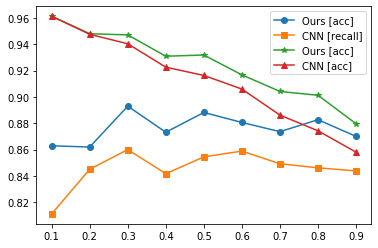

In [19]:
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],recalls_ours, label = 'Ours [acc]', marker = 'o')
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],recalls_cnn, label = 'CNN [recall]', marker = 's')
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],accuracies_ours, label = 'Ours [acc]', marker = '*')
plt.plot([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],accuracies_cnn, label = 'CNN [acc]', marker = '^')
plt.legend()

#### References

- Gao Huang, Zhuang Liu, Laurens van der Maaten, Kilian Q. Weinberger(2016). : Densely Connected Convolutional Networks.
- Jonathan Masci, Ueli Meier, Dan Cire¸san, and J¨urgen Schmidhuber(2011). : Stacked Convolutional Auto-Encoders for Hierarchical Feature Extraction
- Jaime Zabalza, Jinchang Ren, Jiangbin Zheng, Huimin Zhao, Chunmei Qing, Zhijing Yang,Stephen Marshall(2015). : Novel Segmented Stacked AutoEncoder for - Effective Dimensionality Reduction and Feature Extraction in Hyperspectral Imaging